## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1].split('.')[1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

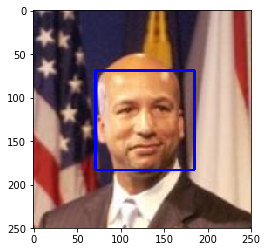

Number of faces detected: 1
*************************


In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

def bounding_onhumanface(imgpath):
    # extract pre-trained face detector
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

    # load color (BGR) image
    img = cv2.imread(imgpath)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))
    print("*************************")
    
bounding_onhumanface(human_files[5])

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def humanface_detector(img_path):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

> **What percentage of the first 100 images in `human_files` have a detected human face?**

The percentage of human faces detected in humanimg are= **100.000%**

> **What percentage of the first 100 images in `dog_files` have a detected human face?**

The percentage of human faces detected in dogimg are= **11.000%** 


In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
import cv2                

print("Testing the performance of the humanface_detector function on the images in human_files_short")
count_humanfaceDetectAlgo_detect_humanface_in_humanimgs=0
for humanimg in human_files_short:
    if(humanface_detector(humanimg)):
        count_humanfaceDetectAlgo_detect_humanface_in_humanimgs += 1
percentage_human_face_detected_in_humanimg=((count_humanfaceDetectAlgo_detect_humanface_in_humanimgs)/len(human_files_short))*100
print("The percentage of human faces detected in humanimg are={0:3.3f}%".format(percentage_human_face_detected_in_humanimg))

print("Testing the performance of the humanface_detector function on the images in dog_files_short")
count_humanfaceDetectAlgo_detect_humanface_in_dogimgs=0
for dogimg in dog_files_short:
    if(humanface_detector(dogimg)):
        count_humanfaceDetectAlgo_detect_humanface_in_dogimgs += 1
percentage_humanface_detected_in_dogimg=((count_humanfaceDetectAlgo_detect_humanface_in_dogimgs)/len(dog_files_short))*100
print("The percentage of human faces detected in dogimg are={0:3.3f}% ".format(percentage_humanface_detected_in_dogimg))


Testing the performance of the humanface_detector function on the images in human_files_short
The percentage of human faces detected in humanimg are=100.000%
Testing the performance of the humanface_detector function on the images in dog_files_short
The percentage of human faces detected in dogimg are=11.000% 


> **__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?**

__Answer:__

Since no algorithm can give us 100% sureity that it only built to detect human faces. 

In all human face detector algo there is atleast 5% probabiltiy that a non-human face is predicted as human face resulting in False positive and a human face sometimes not predicted due to not clearly presented huamn face in image resulting in True negative.
So, i consider it is necessary to tell user beforehand that this algo is for human face detection based on facial feature,shape and size of human face.

 

One more thing to say to user is that the supplied human face image should be straight as above implemented _Haar feature-based cascade classifiers to detect human faces in images_ is sensitive to rotation varience due the Standard Haar-like features are not rotated to identify rotated human faces.(look below images of girl's face as straight and rotated ).


Haar-like features have been used successfully in image sensors for face tracking and
classification problems (Lai et al., 2001; Jones and Viola, 2003; Barreto et al., 2004;
Huang and Lai, 2004), however other problems such as hand tracking (Barczak et al.,
2005; Micilotta and Bowden, 2004; Kölsch and Turk, 2004) have not been so successful.
The main reason for this is the fact that Haar-like features are not invariant over rotation.
This means that any object that rotates and is sensitive to angle changes (such as hands)
will be difficult to solve using standard Haar-like features. The features that define faces
tend to be insensitive to small angle variations and Haar-like features have been used to
detect head rotations of as much as 15o from the vertical (Jones and Viola, 2003). When
people are standing their head is naturally aligned vertically with respect to gravity and so
this rotational sensitivity tends not to be a significant problem for faces. Other body parts
such as hands, arms and legs are not normally alligned with the horizontal or vertical axes
so are difficult to model with traditional Haar-like features. Researchers have tended to
use edge detection or colour based tracking of these parts (Messom et al., 2007).
Several researchers have studied the impact of in plane rotations for image sensors
with the use of twisted Haar-like feature (45o
) (Lienhart and Maydt, 2002; Lienhart et al.,
2003a; 2003b) or diagonal features (Viola and Jones, 2001b) fairly good performance has
been achieved. These techniques will have little benefit for problems that are sensitive to
rotations, such as hand identification (Barczak et al., 2005; Kölsch and Turk, 2004;
Antón-Canalís et al., 2005; Stenger et al, 2004; Wachs et al., 2005) which are not aligned
to fixed angles (0o
, 45o
, 90o etc).

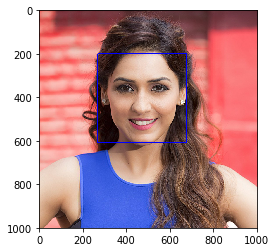

Number of faces detected: 1
*************************
Hello human ur Face is detected


In [9]:

#load test files from dog-project/hooman_images
hooman1= "Hooman_images/hooman_straight.jpg"
hooman2= "Hooman_images/hooman_rotated.jpg"

def check(img_path):
    if(humanface_detector(img_path)):
        bounding_onhumanface(img_path)
        print("Hello human ur Face is detected")
    else:
        print("*****sorry******")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print("Face not detected")
        
check(hooman1)

*****sorry******


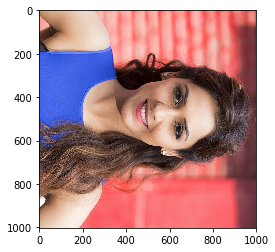

Face not detected


In [10]:
check(hooman2)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [14]:
img = preprocess_input(path_to_tensor(dog_files_short[0]))
img.shape

(1, 224, 224, 3)

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

> **What percentage of the images in `human_files_short` have a detected dog?**

The percentage of dog faces detected in humanimg are= **0.000%**

> **What percentage of the images in `dog_files_short` have a detected dog?**

The percentage of dog faces detected in dogimg are= **100.000%** 


In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
print("Testing the performance of the dog_detector function on the images in human_files_short")
count_dogdetectalgo_detect_dogface_in_humanimgs=0
for humanimg in human_files_short:
    if(dog_detector(humanimg)):
        count_dogdetectalgo_detect_dogface_in_humanimgs += 1
percentage_dog_face_detected_in_humanimg=((count_dogdetectalgo_detect_dogface_in_humanimgs)/len(human_files_short))*100
print("The percentage of dog faces detected in humanimg are={0:3.3f}%".format(percentage_dog_face_detected_in_humanimg))

print("Testing the performance of the dog_detector function on the images in dog_files_short")
count_dogdetectalgo_detect_dogface_in_dogimgs=0
for dogimg in dog_files_short:
    if(dog_detector(dogimg)):
        count_dogdetectalgo_detect_dogface_in_dogimgs += 1
percentage_dog_face_detected_in_dogimg=((count_dogdetectalgo_detect_dogface_in_dogimgs)/len(dog_files_short))*100
print("The percentage of dog faces detected in dogimg are={0:3.3f}% ".format(percentage_dog_face_detected_in_dogimg))


Testing the performance of the dog_detector function on the images in human_files_short
The percentage of dog faces detected in humanimg are=0.000%
Testing the performance of the dog_detector function on the images in dog_files_short
The percentage of dog faces detected in dogimg are=100.000% 


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 100.99it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
> **__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.**

__Answer:__ 
I choose to use above hinted arch. as series of convolutional layer with increasing filter size will allow the network to identify the increasingly complex pattern to better ditnisguish between different dog breed. The pooling layer is usefull to reduce the dimensionalty of convolutional layer it was getting and also reduce overfitting and increase validation accuracy.


In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
#train_tensors.shape=(6680, 224, 224, 3)

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(dog_names),activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [18]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models2/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8835 - acc: 0.0081 - val_loss: 4.8708 - val_acc: 0.0108
Epoch 2/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8691 - acc: 0.0085 - val_loss: 4.8621 - val_acc: 0.0120
Epoch 3/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8470 - acc: 0.0144 - val_loss: 4.8308 - val_acc: 0.0144
Epoch 4/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7928 - acc: 0.0214 - val_loss: 4.7871 - val_acc: 0.0216
Epoch 5/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7527 - acc: 0.0204 - val_loss: 4.7633 - val_acc: 0.0216
Epoch 6/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7252 - acc: 0.0268 - val_loss: 4.7533 - val_acc: 0.0251
Epoch 7/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.6984 - acc: 0.0271 - val_loss: 4.7269 - val_acc: 0.0335
Epoch 8/

### Load the Model with the Best Validation Loss

In [14]:
model.load_weights('saved_models2/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [15]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
#https://youtu.be/3sDYifgjFck?t=56 follow this
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.1866%


In [16]:
train_tensors.shape

(6680, 224, 224, 3)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [15]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [30]:
train_VGG16.shape #this parameters and weights will be the input to new layer for training data..

(6680, 7, 7, 512)

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [16]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [17]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [20]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  

batch_size = [20,35,37,40]
epochs = [20,35,40,50]

fitingdict_vgg16={'Batch_Size':[], 
            'Epochs':[],
            'Test_Accuracy':[]}

for bs in batch_size:
    for ep in epochs:
        checkpointer = ModelCheckpoint(filepath='saved_models1/weights.best.vgg16_bs'+str(bs)+'_ep'+str(ep)+'.hdf5', 
                               verbose=1, save_best_only=True)
        print("\nBatch size={0} Epoch={1}".format(bs,ep))
        VGG16_model.fit(train_VGG16, train_targets,validation_data=(valid_VGG16, valid_targets),
                          epochs=ep , batch_size=bs,
                          callbacks=[checkpointer],verbose=1)

        #LOAD the model with Best validation loss
        VGG16_model.load_weights('saved_models1/weights.best.vgg16_bs'+str(bs)+'_ep'+str(ep)+'.hdf5')

        
        VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
        test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
        fitingdict_vgg16['Batch_Size'].append(bs)
        fitingdict_vgg16['Epochs'].append(ep)
        fitingdict_vgg16['Test_Accuracy'].append(test_accuracy)



Batch size=20 Epoch=20
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 316us/step - loss: 12.2704 - acc: 0.1277 - val_loss: 10.7386 - val_acc: 0.2024
Epoch 2/20
6680/6680 [==============================] - 2s 257us/step - loss: 9.7663 - acc: 0.2963 - val_loss: 9.5612 - val_acc: 0.2982
Epoch 3/20
6680/6680 [==============================] - 2s 252us/step - loss: 9.0173 - acc: 0.3759 - val_loss: 9.3250 - val_acc: 0.3257
Epoch 4/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.7702 - acc: 0.4103 - val_loss: 9.1643 - val_acc: 0.3473
Epoch 5/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.4474 - acc: 0.4346 - val_loss: 8.7721 - val_acc: 0.3737
Epoch 6/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.1527 - acc: 0.4575 - val_loss: 8.6475 - val_acc: 0.3808
Epoch 7/20
6680/6680 [==============================] - 2s 254us/step - loss: 8.0126 - acc: 0.4750 - val_loss: 

Epoch 6/35
6680/6680 [==============================] - 2s 252us/step - loss: 6.3789 - acc: 0.5967 - val_loss: 7.3700 - val_acc: 0.4671
Epoch 7/35
6680/6680 [==============================] - 2s 250us/step - loss: 6.3519 - acc: 0.5991 - val_loss: 7.3553 - val_acc: 0.4659
Epoch 8/35
6680/6680 [==============================] - 2s 250us/step - loss: 6.3257 - acc: 0.6019 - val_loss: 7.3729 - val_acc: 0.4707
Epoch 9/35
6680/6680 [==============================] - 2s 249us/step - loss: 6.2895 - acc: 0.6009 - val_loss: 7.3566 - val_acc: 0.4719
Epoch 10/35
6680/6680 [==============================] - 2s 251us/step - loss: 6.1543 - acc: 0.6072 - val_loss: 7.3031 - val_acc: 0.4659
Epoch 11/35
6680/6680 [==============================] - 2s 250us/step - loss: 6.1104 - acc: 0.6136 - val_loss: 7.2497 - val_acc: 0.4754
Epoch 12/35
6680/6680 [==============================] - 2s 252us/step - loss: 6.0437 - acc: 0.6162 - val_loss: 7.1120 - val_acc: 0.4814
Epoch 13/35
6680/6680 [======================

Epoch 34/35
6680/6680 [==============================] - 2s 252us/step - loss: 5.8062 - acc: 0.6391 - val_loss: 7.0301 - val_acc: 0.4982
Epoch 35/35
6680/6680 [==============================] - 2s 252us/step - loss: 5.8093 - acc: 0.6389 - val_loss: 7.0263 - val_acc: 0.5102

Batch size=20 Epoch=40
Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 2s 253us/step - loss: 5.8120 - acc: 0.6377 - val_loss: 6.9735 - val_acc: 0.5018
Epoch 2/40
6680/6680 [==============================] - 2s 251us/step - loss: 5.8112 - acc: 0.6377 - val_loss: 6.9982 - val_acc: 0.5018
Epoch 3/40
6680/6680 [==============================] - 2s 250us/step - loss: 5.8128 - acc: 0.6377 - val_loss: 7.0417 - val_acc: 0.4874
Epoch 4/40
6680/6680 [==============================] - 2s 251us/step - loss: 5.8105 - acc: 0.6380 - val_loss: 7.0377 - val_acc: 0.4946
Epoch 5/40
6680/6680 [==============================] - 2s 251us/step - loss: 5.8090 - acc: 0.6385 - val_loss: 

Epoch 30/40
6680/6680 [==============================] - 2s 252us/step - loss: 5.7011 - acc: 0.6461 - val_loss: 6.9114 - val_acc: 0.5054
Epoch 31/40
6680/6680 [==============================] - 2s 250us/step - loss: 5.7053 - acc: 0.6455 - val_loss: 6.9656 - val_acc: 0.5042
Epoch 32/40
6680/6680 [==============================] - 2s 254us/step - loss: 5.7020 - acc: 0.6457 - val_loss: 6.9697 - val_acc: 0.5042
Epoch 33/40
6680/6680 [==============================] - 2s 262us/step - loss: 5.7032 - acc: 0.6454 - val_loss: 6.9606 - val_acc: 0.4970
Epoch 34/40
6680/6680 [==============================] - 2s 261us/step - loss: 5.7010 - acc: 0.6455 - val_loss: 6.9941 - val_acc: 0.5030
Epoch 35/40
6680/6680 [==============================] - 2s 262us/step - loss: 5.6928 - acc: 0.6448 - val_loss: 7.0507 - val_acc: 0.5006
Epoch 36/40
6680/6680 [==============================] - 2s 262us/step - loss: 5.6678 - acc: 0.6440 - val_loss: 6.9767 - val_acc: 0.5006
Epoch 37/40
6680/6680 [==================

Epoch 20/50
6680/6680 [==============================] - 2s 250us/step - loss: 5.6055 - acc: 0.6515 - val_loss: 6.8752 - val_acc: 0.5162
Epoch 21/50
6680/6680 [==============================] - 2s 251us/step - loss: 5.6037 - acc: 0.6515 - val_loss: 6.8614 - val_acc: 0.5150
Epoch 22/50
6680/6680 [==============================] - 2s 249us/step - loss: 5.6027 - acc: 0.6519 - val_loss: 6.8699 - val_acc: 0.5114
Epoch 23/50
6680/6680 [==============================] - 2s 250us/step - loss: 5.6056 - acc: 0.6516 - val_loss: 6.8861 - val_acc: 0.5078
Epoch 24/50
6680/6680 [==============================] - 2s 250us/step - loss: 5.6044 - acc: 0.6519 - val_loss: 6.8636 - val_acc: 0.5162
Epoch 25/50
6680/6680 [==============================] - 2s 251us/step - loss: 5.6035 - acc: 0.6516 - val_loss: 6.9273 - val_acc: 0.5102
Epoch 26/50
6680/6680 [==============================] - 2s 251us/step - loss: 5.6037 - acc: 0.6518 - val_loss: 6.9008 - val_acc: 0.5126
Epoch 27/50
6680/6680 [==================

Epoch 2/20
6680/6680 [==============================] - 1s 172us/step - loss: 5.6035 - acc: 0.6518 - val_loss: 6.8882 - val_acc: 0.5138
Epoch 3/20
6680/6680 [==============================] - 1s 172us/step - loss: 5.6056 - acc: 0.6516 - val_loss: 6.8785 - val_acc: 0.5042
Epoch 4/20
6680/6680 [==============================] - 1s 172us/step - loss: 5.6038 - acc: 0.6519 - val_loss: 6.8592 - val_acc: 0.5078
Epoch 5/20
6680/6680 [==============================] - 1s 170us/step - loss: 5.6071 - acc: 0.6518 - val_loss: 6.8654 - val_acc: 0.5090
Epoch 6/20
6680/6680 [==============================] - 1s 172us/step - loss: 5.6059 - acc: 0.6518 - val_loss: 6.8818 - val_acc: 0.5090
Epoch 7/20
6680/6680 [==============================] - 1s 170us/step - loss: 5.6057 - acc: 0.6516 - val_loss: 6.8714 - val_acc: 0.5042
Epoch 8/20
6680/6680 [==============================] - 1s 171us/step - loss: 5.6062 - acc: 0.6516 - val_loss: 6.8600 - val_acc: 0.5090
Epoch 9/20
6680/6680 [==========================

Epoch 9/40
6680/6680 [==============================] - 1s 171us/step - loss: 5.6041 - acc: 0.6516 - val_loss: 6.8621 - val_acc: 0.5126
Epoch 10/40
6680/6680 [==============================] - 1s 171us/step - loss: 5.6041 - acc: 0.6518 - val_loss: 6.9093 - val_acc: 0.5126
Epoch 11/40
6680/6680 [==============================] - 1s 172us/step - loss: 5.6057 - acc: 0.6515 - val_loss: 6.8724 - val_acc: 0.5138
Epoch 12/40
6680/6680 [==============================] - 1s 171us/step - loss: 5.6020 - acc: 0.6521 - val_loss: 6.8571 - val_acc: 0.5150
Epoch 13/40
6680/6680 [==============================] - 1s 172us/step - loss: 5.6042 - acc: 0.6521 - val_loss: 6.8704 - val_acc: 0.5126
Epoch 14/40
6680/6680 [==============================] - 1s 170us/step - loss: 5.6060 - acc: 0.6518 - val_loss: 6.8789 - val_acc: 0.5054
Epoch 15/40
6680/6680 [==============================] - 1s 170us/step - loss: 5.6062 - acc: 0.6518 - val_loss: 6.8822 - val_acc: 0.5138
Epoch 16/40
6680/6680 [===================

6680/6680 [==============================] - 1s 173us/step - loss: 5.6058 - acc: 0.6515 - val_loss: 6.8408 - val_acc: 0.5162
Epoch 2/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6019 - acc: 0.6521 - val_loss: 6.8734 - val_acc: 0.5090
Epoch 3/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6034 - acc: 0.6519 - val_loss: 6.8071 - val_acc: 0.5198
Epoch 4/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6047 - acc: 0.6521 - val_loss: 6.8701 - val_acc: 0.5090
Epoch 5/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6043 - acc: 0.6518 - val_loss: 6.8701 - val_acc: 0.5126
Epoch 6/50
6680/6680 [==============================] - 1s 169us/step - loss: 5.6036 - acc: 0.6521 - val_loss: 6.8549 - val_acc: 0.5114
Epoch 7/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6037 - acc: 0.6521 - val_loss: 6.8582 - val_acc: 0.5114
Epoch 8/50
6680/6680 [==============================] - 1s 

Epoch 33/50
6680/6680 [==============================] - 1s 170us/step - loss: 5.6027 - acc: 0.6519 - val_loss: 6.8928 - val_acc: 0.5078
Epoch 34/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6036 - acc: 0.6518 - val_loss: 6.8671 - val_acc: 0.5138
Epoch 35/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6047 - acc: 0.6515 - val_loss: 6.8647 - val_acc: 0.5090
Epoch 36/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6044 - acc: 0.6516 - val_loss: 6.8632 - val_acc: 0.5102
Epoch 37/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6057 - acc: 0.6519 - val_loss: 6.8559 - val_acc: 0.5114
Epoch 38/50
6680/6680 [==============================] - 1s 171us/step - loss: 5.6041 - acc: 0.6518 - val_loss: 6.8995 - val_acc: 0.5030
Epoch 39/50
6680/6680 [==============================] - 1s 170us/step - loss: 5.6034 - acc: 0.6518 - val_loss: 6.8703 - val_acc: 0.5126
Epoch 40/50
6680/6680 [==================

Epoch 14/20
6680/6680 [==============================] - 1s 166us/step - loss: 5.6051 - acc: 0.6521 - val_loss: 6.8668 - val_acc: 0.5126
Epoch 15/20
6680/6680 [==============================] - 1s 166us/step - loss: 5.6060 - acc: 0.6519 - val_loss: 6.8647 - val_acc: 0.5066
Epoch 16/20
6680/6680 [==============================] - 1s 165us/step - loss: 5.6050 - acc: 0.6521 - val_loss: 6.8759 - val_acc: 0.5114
Epoch 17/20
6680/6680 [==============================] - 1s 165us/step - loss: 5.6058 - acc: 0.6516 - val_loss: 6.8585 - val_acc: 0.5150
Epoch 18/20
6680/6680 [==============================] - 1s 166us/step - loss: 5.6060 - acc: 0.6518 - val_loss: 6.8546 - val_acc: 0.5138
Epoch 19/20
6680/6680 [==============================] - 1s 165us/step - loss: 5.6043 - acc: 0.6518 - val_loss: 6.8596 - val_acc: 0.5090
Epoch 20/20
6680/6680 [==============================] - 1s 166us/step - loss: 5.6025 - acc: 0.6521 - val_loss: 6.8708 - val_acc: 0.5138

Batch size=37 Epoch=35
Train on 6680 sam

Epoch 25/35
6680/6680 [==============================] - 1s 170us/step - loss: 5.6058 - acc: 0.6516 - val_loss: 6.8577 - val_acc: 0.5114
Epoch 26/35
6680/6680 [==============================] - 1s 172us/step - loss: 5.6045 - acc: 0.6518 - val_loss: 6.8488 - val_acc: 0.5138
Epoch 27/35
6680/6680 [==============================] - 1s 171us/step - loss: 5.6047 - acc: 0.6519 - val_loss: 6.8853 - val_acc: 0.5102
Epoch 28/35
6680/6680 [==============================] - 1s 171us/step - loss: 5.6049 - acc: 0.6518 - val_loss: 6.8555 - val_acc: 0.5126
Epoch 29/35
6680/6680 [==============================] - 1s 168us/step - loss: 5.6048 - acc: 0.6518 - val_loss: 6.8373 - val_acc: 0.5126
Epoch 30/35
6680/6680 [==============================] - 1s 165us/step - loss: 5.6053 - acc: 0.6519 - val_loss: 6.8802 - val_acc: 0.5138
Epoch 31/35
6680/6680 [==============================] - 1s 164us/step - loss: 5.6034 - acc: 0.6516 - val_loss: 6.8619 - val_acc: 0.5150
Epoch 32/35
6680/6680 [==================

Epoch 21/40
6680/6680 [==============================] - 1s 164us/step - loss: 5.6049 - acc: 0.6519 - val_loss: 6.8763 - val_acc: 0.5114
Epoch 22/40
6680/6680 [==============================] - 1s 165us/step - loss: 5.6051 - acc: 0.6521 - val_loss: 6.8680 - val_acc: 0.5102
Epoch 23/40
6680/6680 [==============================] - 1s 165us/step - loss: 5.6044 - acc: 0.6519 - val_loss: 6.8543 - val_acc: 0.5102
Epoch 24/40
6680/6680 [==============================] - 1s 164us/step - loss: 5.6043 - acc: 0.6518 - val_loss: 6.8756 - val_acc: 0.5066
Epoch 25/40
6680/6680 [==============================] - 1s 164us/step - loss: 5.6028 - acc: 0.6521 - val_loss: 6.8733 - val_acc: 0.5078
Epoch 26/40
6680/6680 [==============================] - 1s 164us/step - loss: 5.6047 - acc: 0.6516 - val_loss: 6.8621 - val_acc: 0.5078
Epoch 27/40
6680/6680 [==============================] - 1s 165us/step - loss: 5.6018 - acc: 0.6518 - val_loss: 6.9102 - val_acc: 0.5042
Epoch 28/40
6680/6680 [==================

Epoch 43/50
6680/6680 [==============================] - 1s 163us/step - loss: 5.6039 - acc: 0.6519 - val_loss: 6.8826 - val_acc: 0.5006
Epoch 44/50
6680/6680 [==============================] - 1s 164us/step - loss: 5.6040 - acc: 0.6516 - val_loss: 6.8885 - val_acc: 0.5054
Epoch 45/50
6680/6680 [==============================] - 1s 164us/step - loss: 5.6052 - acc: 0.6518 - val_loss: 6.8818 - val_acc: 0.5066
Epoch 46/50
6680/6680 [==============================] - 1s 164us/step - loss: 5.6053 - acc: 0.6515 - val_loss: 6.8721 - val_acc: 0.5078
Epoch 47/50
6680/6680 [==============================] - 1s 165us/step - loss: 5.6052 - acc: 0.6518 - val_loss: 6.8823 - val_acc: 0.5078
Epoch 48/50
6680/6680 [==============================] - 1s 166us/step - loss: 5.6048 - acc: 0.6519 - val_loss: 6.8934 - val_acc: 0.5054
Epoch 49/50
6680/6680 [==============================] - 1s 164us/step - loss: 5.6026 - acc: 0.6521 - val_loss: 6.8890 - val_acc: 0.5066
Epoch 50/50
6680/6680 [==================

Epoch 3/35
6680/6680 [==============================] - 1s 158us/step - loss: 5.6059 - acc: 0.6519 - val_loss: 6.8404 - val_acc: 0.5114
Epoch 4/35
6680/6680 [==============================] - 1s 156us/step - loss: 5.6048 - acc: 0.6518 - val_loss: 6.8492 - val_acc: 0.5126
Epoch 5/35
6680/6680 [==============================] - 1s 156us/step - loss: 5.6047 - acc: 0.6519 - val_loss: 6.8738 - val_acc: 0.5126
Epoch 6/35
6680/6680 [==============================] - 1s 157us/step - loss: 5.6034 - acc: 0.6518 - val_loss: 6.8721 - val_acc: 0.5138
Epoch 7/35
6680/6680 [==============================] - 1s 157us/step - loss: 5.6049 - acc: 0.6515 - val_loss: 6.8715 - val_acc: 0.5114
Epoch 8/35
6680/6680 [==============================] - 1s 156us/step - loss: 5.6040 - acc: 0.6521 - val_loss: 6.8734 - val_acc: 0.5126
Epoch 9/35
6680/6680 [==============================] - 1s 157us/step - loss: 5.6050 - acc: 0.6516 - val_loss: 6.8857 - val_acc: 0.5126
Epoch 10/35
6680/6680 [=========================

Epoch 35/35
6680/6680 [==============================] - 1s 158us/step - loss: 5.6053 - acc: 0.6518 - val_loss: 6.8729 - val_acc: 0.5138

Batch size=40 Epoch=40
Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 1s 158us/step - loss: 5.6038 - acc: 0.6518 - val_loss: 6.8738 - val_acc: 0.5114
Epoch 2/40
6680/6680 [==============================] - 1s 159us/step - loss: 5.6045 - acc: 0.6518 - val_loss: 6.8367 - val_acc: 0.5150
Epoch 3/40
6680/6680 [==============================] - 1s 160us/step - loss: 5.6045 - acc: 0.6518 - val_loss: 6.8666 - val_acc: 0.5102
Epoch 4/40
6680/6680 [==============================] - 1s 157us/step - loss: 5.6040 - acc: 0.6519 - val_loss: 6.8713 - val_acc: 0.5114
Epoch 5/40
6680/6680 [==============================] - 1s 157us/step - loss: 5.6041 - acc: 0.6519 - val_loss: 6.8623 - val_acc: 0.5126
Epoch 6/40
6680/6680 [==============================] - 1s 157us/step - loss: 5.6039 - acc: 0.6519 - val_loss: 6

Epoch 22/50
6680/6680 [==============================] - 1s 157us/step - loss: 5.6053 - acc: 0.6515 - val_loss: 6.8816 - val_acc: 0.5090
Epoch 23/50
6680/6680 [==============================] - 1s 156us/step - loss: 5.6047 - acc: 0.6518 - val_loss: 6.8727 - val_acc: 0.5102
Epoch 24/50
6680/6680 [==============================] - 1s 156us/step - loss: 5.6044 - acc: 0.6518 - val_loss: 6.8731 - val_acc: 0.5078
Epoch 25/50
6680/6680 [==============================] - 1s 157us/step - loss: 5.6045 - acc: 0.6518 - val_loss: 6.8697 - val_acc: 0.5114
Epoch 26/50
6680/6680 [==============================] - 1s 156us/step - loss: 5.6053 - acc: 0.6516 - val_loss: 6.8673 - val_acc: 0.5114
Epoch 27/50
6680/6680 [==============================] - 1s 158us/step - loss: 5.6053 - acc: 0.6516 - val_loss: 6.8905 - val_acc: 0.5090
Epoch 28/50
6680/6680 [==============================] - 1s 157us/step - loss: 5.6062 - acc: 0.6519 - val_loss: 6.8900 - val_acc: 0.5090
Epoch 29/50
6680/6680 [==================

In [26]:
import pandas as pd
pd.DataFrame(fitingdict_vgg16)

Batch_Size  Epochs  Test_Accuracy
0           20      20      45.813397
1           20      35      51.196172
2           20      40      52.033493
3           20      50      52.870813
4           35      20      52.631579
5           35      35      52.870813
6           35      40      53.110048
7           35      50      52.990431
8           37      20      52.990431
9           37      35      52.751196
10          37      40      52.631579
11          37      50      52.990431
12          40      20      52.511962
13          40      35      52.751196
14          40      40      52.272727
15          40      50      52.751196

### Load the Model with the Best Validation Loss

In [21]:
#take largest testaccuracy's batch size and epochs
ind=fitingdict_vgg16['Test_Accuracy'].index(max(fitingdict_vgg16['Test_Accuracy']))
bs=fitingdict_vgg16['Batch_Size'][ind]
ep=fitingdict_vgg16['Epochs'][ind]

#LOAD the model with Best validation loss 
VGG16_model.load_weights('saved_models1/weights.best.vgg16_bs'+str(bs)+'_ep'+str(ep)+'.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [20]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.1100%


### Predict Dog Breed with the Model

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [24]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from keras.preprocessing import image                  
from os import walk
from os import listdir
from os.path import isfile, join
import random
import numpy as np
import cv2


def show_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    plt.imshow(img/255)
    plt.show()
    

def whos_face_is_this_VGG16(img_path):
    if(dog_detector(img_path)):
        print("\n**************************************")
        show_image(img_path)
        print("hello, Doggy!")
        print("Your predicted breed is....")
        print(VGG16_predict_breed(img_path))
        
    elif(humanface_detector(img_path)):
        print("\n**************************************")
        show_image(img_path)
        print("Hello, Human!")
        print("You look like a.... ")
        print(VGG16_predict_breed(img_path))
        
    else:
        print("\n**************************************")
        show_image(img_path)
        print("**No face detected..ERROR..**")


**************************************


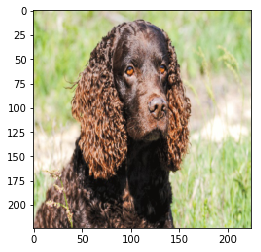

hello, Doggy!
Your predicted breed is....
Boykin_spaniel

**************************************


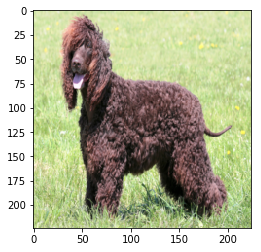

hello, Doggy!
Your predicted breed is....
Irish_water_spaniel

**************************************


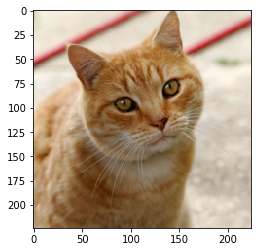

**No face detected..ERROR..**

**************************************


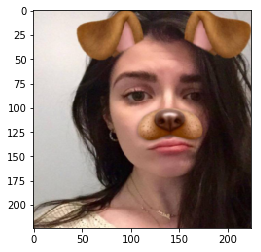

Hello, Human!
You look like a.... 
Dachshund


In [37]:
#Load the img files
imgs=["dog_images/doggy (1).jpg","dog_images/doggy (1a).jpg","Hooman_images/hooman (4).jpg","Hooman_images/hooman (10).jpg"]
for img in imgs:
    whos_face_is_this_VGG16(img)


Above model VGG16 correctly differentiate 2 similar looking dogs into  _Boykin_spaniel and Irish_water_spaniel_ . But, dog predicted _Boykin_spaniel_ was actually _American_water_spaniel_ the wrong prediction here due to Test accuracy of the model is 53.1100% .
 
 This was letter corrected by Xception model giving test acccuracy of 86.8421% .

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

### Lests do with ResNet-50

In [32]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']


### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [33]:
### TODO: Compile the model
ResNet_model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

### TODO: Train the model.

batch_size = [35,37,40,64]
epochs = [25,35,50]

fitingdict_ResNet={'Batch_Size':[], 
            'Epochs':[],
            'Test_Accuracy':[]}

for bs in batch_size:
    for ep in epochs:
        checkpointer = ModelCheckpoint(filepath='saved_models3/weights.best.ResNet_bs'+str(bs)+'_ep'+str(ep)+'.hdf5', 
                               verbose=1, save_best_only=True)
        print("\nBatch size={0} Epoch={1}".format(bs,ep))
        ResNet_model.fit(train_Resnet50, train_targets,validation_data=(valid_Resnet50, valid_targets),
                          epochs=ep , batch_size=bs,
                          callbacks=[checkpointer],verbose=1)

        #LOAD the model with Best validation loss
        ResNet_model.load_weights('saved_models3/weights.best.ResNet_bs'+str(bs)+'_ep'+str(ep)+'.hdf5')

        
        ResNet_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
        test_accuracy = 100*np.sum(np.array(ResNet_predictions)==np.argmax(test_targets, axis=1))/len(ResNet_predictions)
        fitingdict_ResNet['Batch_Size'].append(bs)
        fitingdict_ResNet['Epochs'].append(ep)
        fitingdict_ResNet['Test_Accuracy'].append(test_accuracy)



Batch size=35 Epoch=25
Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 1s 204us/step - loss: 1.8207 - acc: 0.5659 - val_loss: 0.8936 - val_acc: 0.7246
Epoch 2/25
6680/6680 [==============================] - 1s 152us/step - loss: 0.4684 - acc: 0.8594 - val_loss: 0.7264 - val_acc: 0.7808
Epoch 3/25
6680/6680 [==============================] - 1s 145us/step - loss: 0.2609 - acc: 0.9213 - val_loss: 0.6414 - val_acc: 0.7988
Epoch 4/25
6680/6680 [==============================] - 1s 140us/step - loss: 0.1594 - acc: 0.9543 - val_loss: 0.6265 - val_acc: 0.8144
Epoch 5/25
6680/6680 [==============================] - 1s 140us/step - loss: 0.1129 - acc: 0.9696 - val_loss: 0.6381 - val_acc: 0.8096
Epoch 6/25
6680/6680 [==============================] - 1s 140us/step - loss: 0.0743 - acc: 0.9823 - val_loss: 0.6644 - val_acc: 0.8144
Epoch 7/25
6680/6680 [==============================] - 1s 140us/step - loss: 0.0516 - acc: 0.9879 - val_loss: 0.

Epoch 2/50
6680/6680 [==============================] - 1s 140us/step - loss: 0.0276 - acc: 0.9942 - val_loss: 0.6757 - val_acc: 0.8299
Epoch 3/50
6680/6680 [==============================] - 1s 139us/step - loss: 0.0205 - acc: 0.9969 - val_loss: 0.7123 - val_acc: 0.8108
Epoch 4/50
6680/6680 [==============================] - 1s 140us/step - loss: 0.0152 - acc: 0.9964 - val_loss: 0.7267 - val_acc: 0.8204
Epoch 5/50
6680/6680 [==============================] - 1s 138us/step - loss: 0.0125 - acc: 0.9984 - val_loss: 0.7871 - val_acc: 0.8168
Epoch 6/50
6680/6680 [==============================] - 1s 140us/step - loss: 0.0101 - acc: 0.9978 - val_loss: 0.7250 - val_acc: 0.8228
Epoch 7/50
6680/6680 [==============================] - 1s 139us/step - loss: 0.0077 - acc: 0.9988 - val_loss: 0.7569 - val_acc: 0.8311
Epoch 8/50
6680/6680 [==============================] - 1s 139us/step - loss: 0.0081 - acc: 0.9984 - val_loss: 0.7588 - val_acc: 0.8443
Epoch 9/50
6680/6680 [==========================

6680/6680 [==============================] - 1s 148us/step - loss: 0.0049 - acc: 0.9985 - val_loss: 1.1210 - val_acc: 0.8359
Epoch 35/50
6680/6680 [==============================] - 1s 141us/step - loss: 0.0052 - acc: 0.9987 - val_loss: 1.1178 - val_acc: 0.8299
Epoch 36/50
6680/6680 [==============================] - 1s 140us/step - loss: 0.0038 - acc: 0.9990 - val_loss: 1.1435 - val_acc: 0.8311
Epoch 37/50
6680/6680 [==============================] - 1s 139us/step - loss: 0.0040 - acc: 0.9988 - val_loss: 1.1200 - val_acc: 0.8251
Epoch 38/50
6680/6680 [==============================] - 1s 140us/step - loss: 0.0046 - acc: 0.9987 - val_loss: 1.1427 - val_acc: 0.8323
Epoch 39/50
6680/6680 [==============================] - 1s 139us/step - loss: 0.0043 - acc: 0.9988 - val_loss: 1.1291 - val_acc: 0.8383
Epoch 40/50
6680/6680 [==============================] - 1s 139us/step - loss: 0.0049 - acc: 0.9987 - val_loss: 1.1254 - val_acc: 0.8371
Epoch 41/50
6680/6680 [==============================

Epoch 22/35
6680/6680 [==============================] - 1s 133us/step - loss: 0.0041 - acc: 0.9984 - val_loss: 1.0118 - val_acc: 0.8287
Epoch 23/35
6680/6680 [==============================] - 1s 133us/step - loss: 0.0043 - acc: 0.9987 - val_loss: 1.0673 - val_acc: 0.8204
Epoch 24/35
6680/6680 [==============================] - 1s 134us/step - loss: 0.0043 - acc: 0.9987 - val_loss: 1.0225 - val_acc: 0.8347
Epoch 25/35
6680/6680 [==============================] - 1s 133us/step - loss: 0.0045 - acc: 0.9985 - val_loss: 1.0789 - val_acc: 0.8287
Epoch 26/35
6680/6680 [==============================] - 1s 133us/step - loss: 0.0050 - acc: 0.9987 - val_loss: 1.0682 - val_acc: 0.8323
Epoch 27/35
6680/6680 [==============================] - 1s 135us/step - loss: 0.0044 - acc: 0.9988 - val_loss: 1.0933 - val_acc: 0.8251
Epoch 28/35
6680/6680 [==============================] - 1s 134us/step - loss: 0.0049 - acc: 0.9987 - val_loss: 1.0988 - val_acc: 0.8299
Epoch 29/35
6680/6680 [==================

6680/6680 [==============================] - 1s 135us/step - loss: 0.0042 - acc: 0.9985 - val_loss: 1.1684 - val_acc: 0.8335

Batch size=40 Epoch=25
Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 1s 126us/step - loss: 0.0104 - acc: 0.9978 - val_loss: 0.7372 - val_acc: 0.8311
Epoch 2/25
6680/6680 [==============================] - 1s 125us/step - loss: 0.0062 - acc: 0.9982 - val_loss: 0.8063 - val_acc: 0.8263
Epoch 3/25
6680/6680 [==============================] - 1s 126us/step - loss: 0.0060 - acc: 0.9981 - val_loss: 0.7689 - val_acc: 0.8323
Epoch 4/25
6680/6680 [==============================] - 1s 125us/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.8289 - val_acc: 0.8383
Epoch 5/25
6680/6680 [==============================] - 1s 127us/step - loss: 0.0056 - acc: 0.9985 - val_loss: 0.8278 - val_acc: 0.8335
Epoch 6/25
6680/6680 [==============================] - 1s 125us/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.8454 - val_

Epoch 6/35
6680/6680 [==============================] - 1s 124us/step - loss: 0.0044 - acc: 0.9987 - val_loss: 0.8354 - val_acc: 0.8335
Epoch 7/35
6680/6680 [==============================] - 1s 125us/step - loss: 0.0051 - acc: 0.9988 - val_loss: 0.9094 - val_acc: 0.8263
Epoch 8/35
6680/6680 [==============================] - 1s 127us/step - loss: 0.0037 - acc: 0.9985 - val_loss: 0.9048 - val_acc: 0.8251
Epoch 9/35
6680/6680 [==============================] - 1s 125us/step - loss: 0.0046 - acc: 0.9990 - val_loss: 0.8868 - val_acc: 0.8299
Epoch 10/35
6680/6680 [==============================] - 1s 124us/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.9228 - val_acc: 0.8287
Epoch 11/35
6680/6680 [==============================] - 1s 125us/step - loss: 0.0042 - acc: 0.9985 - val_loss: 0.9553 - val_acc: 0.8275
Epoch 12/35
6680/6680 [==============================] - 1s 125us/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.9490 - val_acc: 0.8323
Epoch 13/35
6680/6680 [======================

Epoch 3/50
6680/6680 [==============================] - 1s 126us/step - loss: 0.0047 - acc: 0.9981 - val_loss: 0.7969 - val_acc: 0.8311
Epoch 4/50
6680/6680 [==============================] - 1s 124us/step - loss: 0.0048 - acc: 0.9987 - val_loss: 0.8555 - val_acc: 0.8323
Epoch 5/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.8406 - val_acc: 0.8287
Epoch 6/50
6680/6680 [==============================] - 1s 126us/step - loss: 0.0040 - acc: 0.9985 - val_loss: 0.8918 - val_acc: 0.8204
Epoch 7/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0042 - acc: 0.9985 - val_loss: 0.9074 - val_acc: 0.8287
Epoch 8/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0057 - acc: 0.9988 - val_loss: 0.9107 - val_acc: 0.8347
Epoch 9/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0036 - acc: 0.9988 - val_loss: 0.9490 - val_acc: 0.8275
Epoch 10/50
6680/6680 [=========================

Epoch 35/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0039 - acc: 0.9988 - val_loss: 1.1554 - val_acc: 0.8383
Epoch 36/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0043 - acc: 0.9985 - val_loss: 1.1325 - val_acc: 0.8347
Epoch 37/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0048 - acc: 0.9988 - val_loss: 1.1392 - val_acc: 0.8359
Epoch 38/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0051 - acc: 0.9988 - val_loss: 1.1422 - val_acc: 0.8335
Epoch 39/50
6680/6680 [==============================] - 1s 125us/step - loss: 0.0047 - acc: 0.9987 - val_loss: 1.1545 - val_acc: 0.8335
Epoch 40/50
6680/6680 [==============================] - 1s 123us/step - loss: 0.0044 - acc: 0.9990 - val_loss: 1.1448 - val_acc: 0.8299
Epoch 41/50
6680/6680 [==============================] - 1s 124us/step - loss: 0.0044 - acc: 0.9988 - val_loss: 1.1606 - val_acc: 0.8299
Epoch 42/50
6680/6680 [==================

Epoch 16/25
6680/6680 [==============================] - 1s 88us/step - loss: 0.0042 - acc: 0.9988 - val_loss: 1.0640 - val_acc: 0.8287
Epoch 17/25
6680/6680 [==============================] - 1s 87us/step - loss: 0.0041 - acc: 0.9985 - val_loss: 1.0650 - val_acc: 0.8263
Epoch 18/25
6680/6680 [==============================] - 1s 87us/step - loss: 0.0042 - acc: 0.9988 - val_loss: 1.0656 - val_acc: 0.8168
Epoch 19/25
6680/6680 [==============================] - 1s 87us/step - loss: 0.0035 - acc: 0.9988 - val_loss: 1.0248 - val_acc: 0.8335
Epoch 20/25
6680/6680 [==============================] - 1s 88us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 1.0464 - val_acc: 0.8347
Epoch 21/25
6680/6680 [==============================] - 1s 87us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 1.0585 - val_acc: 0.8347
Epoch 22/25
6680/6680 [==============================] - 1s 87us/step - loss: 0.0042 - acc: 0.9988 - val_loss: 1.0583 - val_acc: 0.8311
Epoch 23/25
6680/6680 [=========================

Epoch 23/35
6680/6680 [==============================] - 1s 88us/step - loss: 0.0042 - acc: 0.9987 - val_loss: 1.0761 - val_acc: 0.8311
Epoch 24/35
6680/6680 [==============================] - 1s 87us/step - loss: 0.0042 - acc: 0.9990 - val_loss: 1.0821 - val_acc: 0.8347
Epoch 25/35
6680/6680 [==============================] - 1s 88us/step - loss: 0.0045 - acc: 0.9991 - val_loss: 1.0882 - val_acc: 0.8311
Epoch 26/35
6680/6680 [==============================] - 1s 88us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 1.0878 - val_acc: 0.8371
Epoch 27/35
6680/6680 [==============================] - 1s 88us/step - loss: 0.0043 - acc: 0.9985 - val_loss: 1.1159 - val_acc: 0.8263
Epoch 28/35
6680/6680 [==============================] - 1s 87us/step - loss: 0.0038 - acc: 0.9987 - val_loss: 1.1045 - val_acc: 0.8383
Epoch 29/35
6680/6680 [==============================] - 1s 88us/step - loss: 0.0045 - acc: 0.9988 - val_loss: 1.0874 - val_acc: 0.8383
Epoch 30/35
6680/6680 [=========================

In [34]:
pd.DataFrame(fitingdict_ResNet)

Batch_Size  Epochs  Test_Accuracy
0           35      25      80.263158
1           35      35      82.296651
2           35      50      81.937799
3           37      25      81.937799
4           37      35      82.057416
5           37      50      80.861244
6           40      25      82.416268
7           40      35      81.818182
8           40      50      81.937799
9           64      25      82.177033
10          64      35      81.339713
11          64      50      81.937799

In [35]:
#take largest testaccuracy's batch size and epochs
ind=fitingdict_ResNet['Test_Accuracy'].index(max(fitingdict_ResNet['Test_Accuracy']))
bs=fitingdict_ResNet['Batch_Size'][ind]
ep=fitingdict_ResNet['Epochs'][ind]

#LOAD the model with Best validation loss 
ResNet_model.load_weights('saved_models3/weights.best.ResNet_bs'+str(bs)+'_ep'+str(ep)+'.hdf5')
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
ResNet_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet_predictions)==np.argmax(test_targets, axis=1))/len(ResNet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.4163%


### lets do with Xception model

In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The below architecture using _Xception model_ is most suitable for current problem as it gave me Test accuracy of 86.8421% which is higher then other model i tested. We can see that in ResNet-50 the _Maximum_ Test accuracy is 	82.4163% on batch_size=40 and epoch=25 and VGG-16 is 53.1100% on batch_size=35 and epoch=40 and in Xception model the Minimum test accuracy is starts from 84.330144%. thats the reason i go with Xception model.
I used with BatchNormalization as Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

In [27]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

Xception_model=Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(BatchNormalization())

# let's add a fully-connected layer
Xception_model.add(Dropout(0.5))
Xception_model.add( Dense(1024, activation='relu'))
Xception_model.add( Dropout(0.5))
# and a logistic layer -- let's say we have NUM_CLASSES classes
Xception_model.add( Dense(len(dog_names), activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               136325    
Total params: 2,242,693
Trainable params: 2,238,597
Non-trainable params: 4,096
______________________________________________________________

### (IMPLEMENTATION) Compile the Model

In [28]:
### TODO: Compile the model
Xception_model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [55]:
### TODO: Train the model.
from sklearn.model_selection import GridSearchCV
# defining the grid search parameters
batch_size = [35,36,37,40,41]
epochs = [35,37,40,50,55]

fitingdict={'Batch_Size':[], 
            'Epochs':[],
            'Test_Accuracy':[]}

for bs in batch_size:
    for ep in epochs:
        checkpointer = ModelCheckpoint(filepath='saved_models2/weights.best.ResNet_bs'+str(bs)+'_ep'+str(ep)+'.hdf5', 
                               verbose=1, save_best_only=True)
        print("\nBatch size={0} Epoch={1}".format(bs,ep))
        Xception_model.fit(train_Xception, train_targets,validation_data=(valid_Xception, valid_targets),
                          epochs=ep , batch_size=bs,
                          callbacks=[checkpointer],verbose=1)

        #LOAD the model with Best validation loss
        Xception_model.load_weights('saved_models2/weights.best.ResNet_bs'+str(bs)+'_ep'+str(ep)+'.hdf5')

        
        Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
        test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
        fitingdict['Batch_Size'].append(bs)
        fitingdict['Epochs'].append(ep)
        fitingdict['Test_Accuracy'].append(test_accuracy)



Batch size=35 Epoch=35
Train on 6680 samples, validate on 835 samples
Epoch 1/35
6680/6680 [==============================] - 4s 558us/step - loss: 0.1990 - acc: 0.9707 - val_loss: 1.4626 - val_acc: 0.8587
Epoch 2/35
6680/6680 [==============================] - 4s 540us/step - loss: 0.2091 - acc: 0.9699 - val_loss: 1.5414 - val_acc: 0.8479
Epoch 3/35
6680/6680 [==============================] - 4s 565us/step - loss: 0.2032 - acc: 0.9678 - val_loss: 1.5532 - val_acc: 0.8455
Epoch 4/35
6680/6680 [==============================] - 4s 548us/step - loss: 0.1905 - acc: 0.9702 - val_loss: 1.5364 - val_acc: 0.8599
Epoch 5/35
6680/6680 [==============================] - 4s 540us/step - loss: 0.2214 - acc: 0.9686 - val_loss: 1.5839 - val_acc: 0.8431
Epoch 6/35
6680/6680 [==============================] - 4s 537us/step - loss: 0.2228 - acc: 0.9678 - val_loss: 1.5875 - val_acc: 0.8491
Epoch 7/35
6680/6680 [==============================] - 4s 544us/step - loss: 0.2210 - acc: 0.9687 - val_loss: 1.

Epoch 33/35
6680/6680 [==============================] - 4s 553us/step - loss: 0.2303 - acc: 0.9702 - val_loss: 1.6698 - val_acc: 0.8587
Epoch 34/35
6680/6680 [==============================] - 4s 560us/step - loss: 0.2148 - acc: 0.9723 - val_loss: 1.6363 - val_acc: 0.8551
Epoch 35/35
6680/6680 [==============================] - 4s 545us/step - loss: 0.1839 - acc: 0.9746 - val_loss: 1.7155 - val_acc: 0.8479

Batch size=35 Epoch=37
Train on 6680 samples, validate on 835 samples
Epoch 1/37
6680/6680 [==============================] - 4s 549us/step - loss: 0.2048 - acc: 0.9686 - val_loss: 1.4999 - val_acc: 0.8467
Epoch 2/37
6680/6680 [==============================] - 4s 542us/step - loss: 0.2071 - acc: 0.9690 - val_loss: 1.5362 - val_acc: 0.8491
Epoch 3/37
6680/6680 [==============================] - 4s 531us/step - loss: 0.1967 - acc: 0.9702 - val_loss: 1.6042 - val_acc: 0.8431
Epoch 4/37
6680/6680 [==============================] - 4s 533us/step - loss: 0.2204 - acc: 0.9680 - val_loss:

Epoch 23/40
6680/6680 [==============================] - 4s 536us/step - loss: 0.2263 - acc: 0.9713 - val_loss: 1.8122 - val_acc: 0.8419
Epoch 24/40
6680/6680 [==============================] - 4s 540us/step - loss: 0.2358 - acc: 0.9692 - val_loss: 1.8351 - val_acc: 0.8395
Epoch 25/40
6680/6680 [==============================] - 4s 538us/step - loss: 0.2148 - acc: 0.9716 - val_loss: 1.7378 - val_acc: 0.8539
Epoch 26/40
6680/6680 [==============================] - 4s 548us/step - loss: 0.2240 - acc: 0.9719 - val_loss: 1.6965 - val_acc: 0.8491
Epoch 27/40
6680/6680 [==============================] - 4s 541us/step - loss: 0.2214 - acc: 0.9704 - val_loss: 1.7100 - val_acc: 0.8479
Epoch 28/40
6680/6680 [==============================] - 4s 549us/step - loss: 0.2177 - acc: 0.9695 - val_loss: 1.6952 - val_acc: 0.8551
Epoch 29/40
6680/6680 [==============================] - 4s 551us/step - loss: 0.1807 - acc: 0.9746 - val_loss: 1.7109 - val_acc: 0.8491
Epoch 30/40
6680/6680 [==================

Epoch 14/50
6680/6680 [==============================] - 4s 533us/step - loss: 0.2176 - acc: 0.9704 - val_loss: 1.5892 - val_acc: 0.8623
Epoch 15/50
6680/6680 [==============================] - 4s 542us/step - loss: 0.2322 - acc: 0.9678 - val_loss: 1.5724 - val_acc: 0.8587
Epoch 16/50
6680/6680 [==============================] - 4s 540us/step - loss: 0.2082 - acc: 0.9716 - val_loss: 1.6042 - val_acc: 0.8599
Epoch 17/50
6680/6680 [==============================] - 4s 557us/step - loss: 0.2040 - acc: 0.9729 - val_loss: 1.6621 - val_acc: 0.8539
Epoch 18/50
6680/6680 [==============================] - 4s 547us/step - loss: 0.2208 - acc: 0.9696 - val_loss: 1.6563 - val_acc: 0.8479
Epoch 19/50
6680/6680 [==============================] - 4s 544us/step - loss: 0.1901 - acc: 0.9738 - val_loss: 1.5439 - val_acc: 0.8599
Epoch 20/50
6680/6680 [==============================] - 4s 558us/step - loss: 0.2350 - acc: 0.9690 - val_loss: 1.6316 - val_acc: 0.8563
Epoch 21/50
6680/6680 [==================

6680/6680 [==============================] - 4s 535us/step - loss: 0.2174 - acc: 0.9740 - val_loss: 1.6796 - val_acc: 0.8455
Epoch 47/50
6680/6680 [==============================] - 4s 540us/step - loss: 0.2011 - acc: 0.9751 - val_loss: 1.7013 - val_acc: 0.8551
Epoch 48/50
6680/6680 [==============================] - 4s 539us/step - loss: 0.1748 - acc: 0.9766 - val_loss: 1.7327 - val_acc: 0.8491
Epoch 49/50
6680/6680 [==============================] - 4s 550us/step - loss: 0.2027 - acc: 0.9754 - val_loss: 1.7723 - val_acc: 0.8563
Epoch 50/50
6680/6680 [==============================] - 4s 547us/step - loss: 0.2282 - acc: 0.9699 - val_loss: 1.6563 - val_acc: 0.8611

Batch size=35 Epoch=55
Train on 6680 samples, validate on 835 samples
Epoch 1/55
6680/6680 [==============================] - 4s 543us/step - loss: 0.2318 - acc: 0.9671 - val_loss: 1.5350 - val_acc: 0.8527
Epoch 2/55
6680/6680 [==============================] - 4s 531us/step - loss: 0.2299 - acc: 0.9675 - val_loss: 1.5563 - 

Epoch 28/55
6680/6680 [==============================] - 4s 545us/step - loss: 0.2176 - acc: 0.9702 - val_loss: 1.7171 - val_acc: 0.8407
Epoch 29/55
6680/6680 [==============================] - 4s 537us/step - loss: 0.1939 - acc: 0.9747 - val_loss: 1.7295 - val_acc: 0.8407
Epoch 30/55
6680/6680 [==============================] - 4s 539us/step - loss: 0.2375 - acc: 0.9693 - val_loss: 1.7486 - val_acc: 0.8431
Epoch 31/55
6680/6680 [==============================] - 4s 540us/step - loss: 0.2279 - acc: 0.9708 - val_loss: 1.6858 - val_acc: 0.8491
Epoch 32/55
6680/6680 [==============================] - 4s 546us/step - loss: 0.2042 - acc: 0.9726 - val_loss: 1.8060 - val_acc: 0.8407
Epoch 33/55
6680/6680 [==============================] - 4s 546us/step - loss: 0.1863 - acc: 0.9756 - val_loss: 1.8319 - val_acc: 0.8371
Epoch 34/55
6680/6680 [==============================] - 4s 536us/step - loss: 0.1862 - acc: 0.9750 - val_loss: 1.7339 - val_acc: 0.8467
Epoch 35/55
6680/6680 [==================


Batch size=36 Epoch=37
Train on 6680 samples, validate on 835 samples
Epoch 1/37
6680/6680 [==============================] - 4s 553us/step - loss: 0.2059 - acc: 0.9720 - val_loss: 1.7084 - val_acc: 0.8503
Epoch 2/37
6680/6680 [==============================] - 4s 549us/step - loss: 0.2355 - acc: 0.9701 - val_loss: 1.6858 - val_acc: 0.8455
Epoch 3/37
6680/6680 [==============================] - 4s 540us/step - loss: 0.2309 - acc: 0.9684 - val_loss: 1.7367 - val_acc: 0.8467
Epoch 4/37
6680/6680 [==============================] - 4s 545us/step - loss: 0.1972 - acc: 0.9707 - val_loss: 1.7250 - val_acc: 0.8503
Epoch 5/37
6680/6680 [==============================] - 4s 544us/step - loss: 0.2337 - acc: 0.9678 - val_loss: 1.6995 - val_acc: 0.8503
Epoch 6/37
6680/6680 [==============================] - 4s 542us/step - loss: 0.2485 - acc: 0.9680 - val_loss: 1.7817 - val_acc: 0.8395
Epoch 7/37
6680/6680 [==============================] - 4s 549us/step - loss: 0.1966 - acc: 0.9744 - val_loss: 1.

Epoch 32/37
6680/6680 [==============================] - 4s 535us/step - loss: 0.2034 - acc: 0.9726 - val_loss: 1.7111 - val_acc: 0.8599
Epoch 33/37
6680/6680 [==============================] - 4s 534us/step - loss: 0.1909 - acc: 0.9763 - val_loss: 1.8571 - val_acc: 0.8479
Epoch 34/37
6680/6680 [==============================] - 4s 528us/step - loss: 0.1975 - acc: 0.9757 - val_loss: 1.8084 - val_acc: 0.8527
Epoch 35/37
6680/6680 [==============================] - 4s 530us/step - loss: 0.2098 - acc: 0.9729 - val_loss: 1.7654 - val_acc: 0.8467
Epoch 36/37
6680/6680 [==============================] - 4s 529us/step - loss: 0.1865 - acc: 0.9780 - val_loss: 1.7981 - val_acc: 0.8431
Epoch 37/37
6680/6680 [==============================] - 4s 532us/step - loss: 0.1938 - acc: 0.9765 - val_loss: 1.7574 - val_acc: 0.8563

Batch size=36 Epoch=40
Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 4s 554us/step - loss: 0.2234 - acc: 0.9681 - val_lo

Epoch 25/40
6680/6680 [==============================] - 4s 539us/step - loss: 0.1923 - acc: 0.9750 - val_loss: 1.7605 - val_acc: 0.8623
Epoch 26/40
6680/6680 [==============================] - 4s 534us/step - loss: 0.1968 - acc: 0.9741 - val_loss: 1.8156 - val_acc: 0.8491
Epoch 27/40
6680/6680 [==============================] - 4s 541us/step - loss: 0.2075 - acc: 0.9740 - val_loss: 1.7038 - val_acc: 0.8551
Epoch 28/40
6680/6680 [==============================] - 4s 539us/step - loss: 0.2197 - acc: 0.9741 - val_loss: 1.7445 - val_acc: 0.8563
Epoch 29/40
6680/6680 [==============================] - 4s 533us/step - loss: 0.2386 - acc: 0.9710 - val_loss: 1.7786 - val_acc: 0.8587
Epoch 30/40
6680/6680 [==============================] - 4s 531us/step - loss: 0.1775 - acc: 0.9766 - val_loss: 1.8230 - val_acc: 0.8503
Epoch 31/40
6680/6680 [==============================] - 4s 532us/step - loss: 0.2203 - acc: 0.9723 - val_loss: 1.7785 - val_acc: 0.8551
Epoch 32/40
6680/6680 [==================

Epoch 16/50
6680/6680 [==============================] - 4s 528us/step - loss: 0.1902 - acc: 0.9746 - val_loss: 1.6840 - val_acc: 0.8503
Epoch 17/50
6680/6680 [==============================] - 4s 529us/step - loss: 0.2065 - acc: 0.9746 - val_loss: 1.6973 - val_acc: 0.8563
Epoch 18/50
6680/6680 [==============================] - 4s 529us/step - loss: 0.1905 - acc: 0.9743 - val_loss: 1.6814 - val_acc: 0.8599
Epoch 19/50
6680/6680 [==============================] - 4s 535us/step - loss: 0.2051 - acc: 0.9734 - val_loss: 1.7473 - val_acc: 0.8575
Epoch 20/50
6680/6680 [==============================] - 4s 553us/step - loss: 0.1697 - acc: 0.9784 - val_loss: 1.6989 - val_acc: 0.8575
Epoch 21/50
6680/6680 [==============================] - 4s 525us/step - loss: 0.2127 - acc: 0.9717 - val_loss: 1.7971 - val_acc: 0.8515
Epoch 22/50
6680/6680 [==============================] - 3s 522us/step - loss: 0.2013 - acc: 0.9760 - val_loss: 1.8139 - val_acc: 0.8491
Epoch 23/50
6680/6680 [==================

6680/6680 [==============================] - 4s 534us/step - loss: 0.1940 - acc: 0.9762 - val_loss: 1.8177 - val_acc: 0.8599
Epoch 49/50
6680/6680 [==============================] - 4s 530us/step - loss: 0.1751 - acc: 0.9783 - val_loss: 1.8535 - val_acc: 0.8515
Epoch 50/50
6680/6680 [==============================] - 4s 534us/step - loss: 0.1936 - acc: 0.9772 - val_loss: 1.7073 - val_acc: 0.8611

Batch size=36 Epoch=55
Train on 6680 samples, validate on 835 samples
Epoch 1/55
6680/6680 [==============================] - 4s 542us/step - loss: 0.2117 - acc: 0.9754 - val_loss: 1.6739 - val_acc: 0.8479
Epoch 2/55
6680/6680 [==============================] - 4s 531us/step - loss: 0.2079 - acc: 0.9728 - val_loss: 1.6450 - val_acc: 0.8599
Epoch 3/55
6680/6680 [==============================] - 4s 527us/step - loss: 0.1986 - acc: 0.9737 - val_loss: 1.7052 - val_acc: 0.8491
Epoch 4/55
6680/6680 [==============================] - 4s 541us/step - loss: 0.2323 - acc: 0.9717 - val_loss: 1.7535 - va

Epoch 29/55
6680/6680 [==============================] - 4s 534us/step - loss: 0.2000 - acc: 0.9747 - val_loss: 1.8471 - val_acc: 0.8515
Epoch 30/55
6680/6680 [==============================] - 4s 538us/step - loss: 0.2079 - acc: 0.9751 - val_loss: 1.8337 - val_acc: 0.8551
Epoch 31/55
6680/6680 [==============================] - 4s 540us/step - loss: 0.2258 - acc: 0.9734 - val_loss: 1.8259 - val_acc: 0.8527
Epoch 32/55
6680/6680 [==============================] - 4s 530us/step - loss: 0.2025 - acc: 0.9775 - val_loss: 1.8255 - val_acc: 0.8479
Epoch 33/55
6680/6680 [==============================] - 4s 531us/step - loss: 0.1932 - acc: 0.9772 - val_loss: 1.8402 - val_acc: 0.8515
Epoch 34/55
6680/6680 [==============================] - 4s 532us/step - loss: 0.1810 - acc: 0.9778 - val_loss: 1.8115 - val_acc: 0.8503
Epoch 35/55
6680/6680 [==============================] - 4s 528us/step - loss: 0.2068 - acc: 0.9750 - val_loss: 1.8045 - val_acc: 0.8455
Epoch 36/55
6680/6680 [==================

Epoch 2/37
6680/6680 [==============================] - 4s 534us/step - loss: 0.1984 - acc: 0.9756 - val_loss: 1.7902 - val_acc: 0.8575
Epoch 3/37
6680/6680 [==============================] - 4s 533us/step - loss: 0.1876 - acc: 0.9781 - val_loss: 1.7333 - val_acc: 0.8647
Epoch 4/37
6680/6680 [==============================] - 4s 533us/step - loss: 0.1744 - acc: 0.9804 - val_loss: 1.6864 - val_acc: 0.8575
Epoch 5/37
6680/6680 [==============================] - 4s 534us/step - loss: 0.1860 - acc: 0.9769 - val_loss: 1.7823 - val_acc: 0.8539
Epoch 6/37
6680/6680 [==============================] - 4s 527us/step - loss: 0.2261 - acc: 0.9723 - val_loss: 1.7973 - val_acc: 0.8587
Epoch 7/37
6680/6680 [==============================] - 4s 536us/step - loss: 0.1835 - acc: 0.9783 - val_loss: 1.6656 - val_acc: 0.8611
Epoch 8/37
6680/6680 [==============================] - 4s 527us/step - loss: 0.1983 - acc: 0.9766 - val_loss: 1.6746 - val_acc: 0.8611
Epoch 9/37
6680/6680 [==========================

Epoch 34/37
6680/6680 [==============================] - 4s 529us/step - loss: 0.1602 - acc: 0.9820 - val_loss: 1.8442 - val_acc: 0.8515
Epoch 35/37
6680/6680 [==============================] - 3s 518us/step - loss: 0.1754 - acc: 0.9804 - val_loss: 1.8948 - val_acc: 0.8467
Epoch 36/37
6680/6680 [==============================] - 4s 525us/step - loss: 0.1979 - acc: 0.9778 - val_loss: 1.8400 - val_acc: 0.8563
Epoch 37/37
6680/6680 [==============================] - 4s 527us/step - loss: 0.1799 - acc: 0.9799 - val_loss: 1.8637 - val_acc: 0.8587

Batch size=37 Epoch=40
Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 4s 542us/step - loss: 0.1958 - acc: 0.9775 - val_loss: 1.7526 - val_acc: 0.8575
Epoch 2/40
6680/6680 [==============================] - 4s 535us/step - loss: 0.1756 - acc: 0.9777 - val_loss: 1.6634 - val_acc: 0.8647
Epoch 3/40
6680/6680 [==============================] - 4s 528us/step - loss: 0.2010 - acc: 0.9768 - val_loss

Epoch 20/50
6680/6680 [==============================] - 3s 523us/step - loss: 0.1862 - acc: 0.9780 - val_loss: 1.8544 - val_acc: 0.8551
Epoch 21/50
6680/6680 [==============================] - 3s 523us/step - loss: 0.1715 - acc: 0.9799 - val_loss: 1.8036 - val_acc: 0.8503
Epoch 22/50
6680/6680 [==============================] - 4s 528us/step - loss: 0.1697 - acc: 0.9783 - val_loss: 1.7974 - val_acc: 0.8587
Epoch 23/50
6680/6680 [==============================] - 3s 524us/step - loss: 0.1886 - acc: 0.9792 - val_loss: 1.8484 - val_acc: 0.8551
Epoch 24/50
6680/6680 [==============================] - 3s 520us/step - loss: 0.2295 - acc: 0.9756 - val_loss: 1.7813 - val_acc: 0.8539
Epoch 25/50
6680/6680 [==============================] - 4s 526us/step - loss: 0.1782 - acc: 0.9784 - val_loss: 1.7815 - val_acc: 0.8527
Epoch 26/50
6680/6680 [==============================] - 4s 526us/step - loss: 0.1851 - acc: 0.9771 - val_loss: 1.8443 - val_acc: 0.8563
Epoch 27/50
6680/6680 [==================

Epoch 2/55
6680/6680 [==============================] - 3s 522us/step - loss: 0.1600 - acc: 0.9798 - val_loss: 1.7343 - val_acc: 0.8539
Epoch 3/55
6680/6680 [==============================] - 3s 523us/step - loss: 0.1649 - acc: 0.9801 - val_loss: 1.7073 - val_acc: 0.8611
Epoch 4/55
6680/6680 [==============================] - 4s 527us/step - loss: 0.2064 - acc: 0.9769 - val_loss: 1.7214 - val_acc: 0.8575
Epoch 5/55
6680/6680 [==============================] - 4s 534us/step - loss: 0.1907 - acc: 0.9777 - val_loss: 1.6421 - val_acc: 0.8647
Epoch 6/55
6680/6680 [==============================] - 4s 530us/step - loss: 0.1819 - acc: 0.9778 - val_loss: 1.6608 - val_acc: 0.8599
Epoch 7/55
6680/6680 [==============================] - 4s 525us/step - loss: 0.1618 - acc: 0.9822 - val_loss: 1.7832 - val_acc: 0.8575
Epoch 8/55
6680/6680 [==============================] - 3s 521us/step - loss: 0.1806 - acc: 0.9792 - val_loss: 1.6746 - val_acc: 0.8551
Epoch 9/55
6680/6680 [==========================

Epoch 34/55
6680/6680 [==============================] - 4s 528us/step - loss: 0.1660 - acc: 0.9819 - val_loss: 1.7976 - val_acc: 0.8563
Epoch 35/55
6680/6680 [==============================] - 3s 524us/step - loss: 0.1618 - acc: 0.9813 - val_loss: 1.7568 - val_acc: 0.8551
Epoch 36/55
6680/6680 [==============================] - 4s 538us/step - loss: 0.1965 - acc: 0.9789 - val_loss: 1.7379 - val_acc: 0.8599
Epoch 37/55
6680/6680 [==============================] - 4s 540us/step - loss: 0.1891 - acc: 0.9786 - val_loss: 1.8782 - val_acc: 0.8515
Epoch 38/55
6680/6680 [==============================] - 4s 539us/step - loss: 0.1940 - acc: 0.9781 - val_loss: 1.8125 - val_acc: 0.8599
Epoch 39/55
6680/6680 [==============================] - 4s 531us/step - loss: 0.1657 - acc: 0.9801 - val_loss: 1.8360 - val_acc: 0.8515
Epoch 40/55
6680/6680 [==============================] - 4s 535us/step - loss: 0.1573 - acc: 0.9816 - val_loss: 1.8390 - val_acc: 0.8575
Epoch 41/55
6680/6680 [==================

Epoch 11/35
6680/6680 [==============================] - 3s 503us/step - loss: 0.1760 - acc: 0.9790 - val_loss: 1.7870 - val_acc: 0.8647
Epoch 12/35
6680/6680 [==============================] - 3s 504us/step - loss: 0.1664 - acc: 0.9811 - val_loss: 1.7707 - val_acc: 0.8575
Epoch 13/35
6680/6680 [==============================] - 3s 501us/step - loss: 0.1744 - acc: 0.9811 - val_loss: 1.9160 - val_acc: 0.8527
Epoch 14/35
6680/6680 [==============================] - 3s 503us/step - loss: 0.1294 - acc: 0.9835 - val_loss: 1.7822 - val_acc: 0.8539
Epoch 15/35
6680/6680 [==============================] - 3s 501us/step - loss: 0.2017 - acc: 0.9798 - val_loss: 1.7164 - val_acc: 0.8647
Epoch 16/35
6680/6680 [==============================] - 3s 518us/step - loss: 0.1886 - acc: 0.9783 - val_loss: 1.8609 - val_acc: 0.8563
Epoch 17/35
6680/6680 [==============================] - 3s 511us/step - loss: 0.2102 - acc: 0.9783 - val_loss: 1.7558 - val_acc: 0.8599
Epoch 18/35
6680/6680 [==================

6680/6680 [==============================] - 3s 506us/step - loss: 0.1673 - acc: 0.9814 - val_loss: 1.6660 - val_acc: 0.8623
Epoch 2/40
6680/6680 [==============================] - 3s 499us/step - loss: 0.1755 - acc: 0.9793 - val_loss: 1.7194 - val_acc: 0.8671
Epoch 3/40
6680/6680 [==============================] - 3s 517us/step - loss: 0.1558 - acc: 0.9811 - val_loss: 1.7532 - val_acc: 0.8587
Epoch 4/40
6680/6680 [==============================] - 3s 500us/step - loss: 0.1663 - acc: 0.9810 - val_loss: 1.8292 - val_acc: 0.8539
Epoch 5/40
6680/6680 [==============================] - 3s 505us/step - loss: 0.1898 - acc: 0.9789 - val_loss: 1.8116 - val_acc: 0.8503
Epoch 6/40
6680/6680 [==============================] - 3s 513us/step - loss: 0.1614 - acc: 0.9822 - val_loss: 1.8134 - val_acc: 0.8587
Epoch 7/40
6680/6680 [==============================] - 3s 507us/step - loss: 0.1446 - acc: 0.9825 - val_loss: 1.8291 - val_acc: 0.8503
Epoch 8/40
6680/6680 [==============================] - 3s 

Epoch 33/40
6680/6680 [==============================] - 3s 517us/step - loss: 0.1880 - acc: 0.9814 - val_loss: 1.8879 - val_acc: 0.8539
Epoch 34/40
6680/6680 [==============================] - 3s 511us/step - loss: 0.1749 - acc: 0.9819 - val_loss: 1.9445 - val_acc: 0.8467
Epoch 35/40
6680/6680 [==============================] - 3s 502us/step - loss: 0.1612 - acc: 0.9814 - val_loss: 1.8904 - val_acc: 0.8551
Epoch 36/40
6680/6680 [==============================] - 3s 501us/step - loss: 0.1922 - acc: 0.9805 - val_loss: 1.9146 - val_acc: 0.8515
Epoch 37/40
6680/6680 [==============================] - 3s 513us/step - loss: 0.1257 - acc: 0.9855 - val_loss: 1.8853 - val_acc: 0.8527
Epoch 38/40
6680/6680 [==============================] - 3s 510us/step - loss: 0.1502 - acc: 0.9832 - val_loss: 1.9265 - val_acc: 0.8587
Epoch 39/40
6680/6680 [==============================] - 3s 501us/step - loss: 0.1478 - acc: 0.9850 - val_loss: 1.8337 - val_acc: 0.8575
Epoch 40/40
6680/6680 [==================

Epoch 25/50
6680/6680 [==============================] - 3s 506us/step - loss: 0.1646 - acc: 0.9819 - val_loss: 1.7789 - val_acc: 0.8539
Epoch 26/50
6680/6680 [==============================] - 3s 513us/step - loss: 0.1473 - acc: 0.9801 - val_loss: 1.7190 - val_acc: 0.8659
Epoch 27/50
6680/6680 [==============================] - 3s 506us/step - loss: 0.1908 - acc: 0.9793 - val_loss: 1.7700 - val_acc: 0.8599
Epoch 28/50
6680/6680 [==============================] - 3s 505us/step - loss: 0.1725 - acc: 0.9808 - val_loss: 1.7738 - val_acc: 0.8611
Epoch 29/50
6680/6680 [==============================] - 3s 505us/step - loss: 0.1526 - acc: 0.9835 - val_loss: 1.7690 - val_acc: 0.8659
Epoch 30/50
6680/6680 [==============================] - 3s 503us/step - loss: 0.1610 - acc: 0.9820 - val_loss: 1.8384 - val_acc: 0.8623
Epoch 31/50
6680/6680 [==============================] - 3s 510us/step - loss: 0.1551 - acc: 0.9820 - val_loss: 1.8316 - val_acc: 0.8575
Epoch 32/50
6680/6680 [==================

6680/6680 [==============================] - 3s 507us/step - loss: 0.1263 - acc: 0.9849 - val_loss: 1.8828 - val_acc: 0.8587
Epoch 39/55
6680/6680 [==============================] - 3s 506us/step - loss: 0.1797 - acc: 0.9807 - val_loss: 1.9087 - val_acc: 0.8587
Epoch 40/55
6680/6680 [==============================] - 3s 513us/step - loss: 0.1677 - acc: 0.9805 - val_loss: 1.9354 - val_acc: 0.8551
Epoch 41/55
6680/6680 [==============================] - 3s 507us/step - loss: 0.1580 - acc: 0.9816 - val_loss: 1.8835 - val_acc: 0.8551
Epoch 42/55
6680/6680 [==============================] - 3s 510us/step - loss: 0.1621 - acc: 0.9819 - val_loss: 1.8344 - val_acc: 0.8563
Epoch 43/55
6680/6680 [==============================] - 3s 516us/step - loss: 0.1608 - acc: 0.9846 - val_loss: 1.9193 - val_acc: 0.8527
Epoch 44/55
6680/6680 [==============================] - 3s 503us/step - loss: 0.1662 - acc: 0.9807 - val_loss: 1.8708 - val_acc: 0.8539
Epoch 45/55
6680/6680 [==============================

Epoch 15/35
6680/6680 [==============================] - 3s 501us/step - loss: 0.1522 - acc: 0.9835 - val_loss: 1.8691 - val_acc: 0.8599
Epoch 16/35
6680/6680 [==============================] - 3s 497us/step - loss: 0.1624 - acc: 0.9804 - val_loss: 1.8703 - val_acc: 0.8539
Epoch 17/35
6680/6680 [==============================] - 3s 506us/step - loss: 0.1552 - acc: 0.9846 - val_loss: 1.8261 - val_acc: 0.8563
Epoch 18/35
6680/6680 [==============================] - 3s 507us/step - loss: 0.1755 - acc: 0.9796 - val_loss: 1.7643 - val_acc: 0.8515
Epoch 19/35
6680/6680 [==============================] - 3s 501us/step - loss: 0.1895 - acc: 0.9802 - val_loss: 1.7363 - val_acc: 0.8575
Epoch 20/35
6680/6680 [==============================] - 3s 496us/step - loss: 0.1541 - acc: 0.9829 - val_loss: 1.7357 - val_acc: 0.8623
Epoch 21/35
6680/6680 [==============================] - 3s 504us/step - loss: 0.1670 - acc: 0.9799 - val_loss: 1.7545 - val_acc: 0.8599
Epoch 22/35
6680/6680 [==================

Epoch 11/37
6680/6680 [==============================] - 3s 515us/step - loss: 0.1687 - acc: 0.9811 - val_loss: 1.8171 - val_acc: 0.8503
Epoch 12/37
6680/6680 [==============================] - 3s 498us/step - loss: 0.1636 - acc: 0.9819 - val_loss: 1.8267 - val_acc: 0.8527
Epoch 13/37
6680/6680 [==============================] - 3s 504us/step - loss: 0.1206 - acc: 0.9850 - val_loss: 1.7853 - val_acc: 0.8599
Epoch 14/37
6680/6680 [==============================] - 3s 499us/step - loss: 0.1822 - acc: 0.9796 - val_loss: 1.8008 - val_acc: 0.8539
Epoch 15/37
6680/6680 [==============================] - 3s 502us/step - loss: 0.1601 - acc: 0.9820 - val_loss: 1.7627 - val_acc: 0.8563
Epoch 16/37
6680/6680 [==============================] - 3s 499us/step - loss: 0.1546 - acc: 0.9832 - val_loss: 1.8442 - val_acc: 0.8611
Epoch 17/37
6680/6680 [==============================] - 3s 496us/step - loss: 0.1536 - acc: 0.9825 - val_loss: 1.8406 - val_acc: 0.8491
Epoch 18/37
6680/6680 [==================

Epoch 6/40
6680/6680 [==============================] - 3s 505us/step - loss: 0.1870 - acc: 0.9801 - val_loss: 1.7614 - val_acc: 0.8635
Epoch 7/40
6680/6680 [==============================] - 3s 499us/step - loss: 0.1775 - acc: 0.9808 - val_loss: 1.7600 - val_acc: 0.8707
Epoch 8/40
6680/6680 [==============================] - 3s 503us/step - loss: 0.1503 - acc: 0.9831 - val_loss: 1.7361 - val_acc: 0.8635
Epoch 9/40
6680/6680 [==============================] - 3s 499us/step - loss: 0.1861 - acc: 0.9793 - val_loss: 1.8424 - val_acc: 0.8539
Epoch 10/40
6680/6680 [==============================] - 3s 503us/step - loss: 0.1911 - acc: 0.9786 - val_loss: 1.7495 - val_acc: 0.8551
Epoch 11/40
6680/6680 [==============================] - 3s 507us/step - loss: 0.1922 - acc: 0.9802 - val_loss: 1.7781 - val_acc: 0.8623
Epoch 12/40
6680/6680 [==============================] - 3s 501us/step - loss: 0.1585 - acc: 0.9828 - val_loss: 1.7773 - val_acc: 0.8575
Epoch 13/40
6680/6680 [======================

Epoch 38/40
6680/6680 [==============================] - 3s 507us/step - loss: 0.1302 - acc: 0.9838 - val_loss: 1.8256 - val_acc: 0.8491
Epoch 39/40
6680/6680 [==============================] - 3s 516us/step - loss: 0.1389 - acc: 0.9841 - val_loss: 1.8739 - val_acc: 0.8575
Epoch 40/40
6680/6680 [==============================] - 3s 505us/step - loss: 0.1382 - acc: 0.9846 - val_loss: 1.8535 - val_acc: 0.8587

Batch size=41 Epoch=50
Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 3s 505us/step - loss: 0.1908 - acc: 0.9790 - val_loss: 1.6537 - val_acc: 0.8683
Epoch 2/50
6680/6680 [==============================] - 3s 508us/step - loss: 0.1598 - acc: 0.9817 - val_loss: 1.7019 - val_acc: 0.8563
Epoch 3/50
6680/6680 [==============================] - 3s 501us/step - loss: 0.1328 - acc: 0.9846 - val_loss: 1.7150 - val_acc: 0.8587
Epoch 4/50
6680/6680 [==============================] - 3s 498us/step - loss: 0.1709 - acc: 0.9807 - val_loss:

Epoch 30/50
6680/6680 [==============================] - 3s 500us/step - loss: 0.1588 - acc: 0.9825 - val_loss: 1.8551 - val_acc: 0.8587
Epoch 31/50
6680/6680 [==============================] - 3s 496us/step - loss: 0.1476 - acc: 0.9840 - val_loss: 1.8314 - val_acc: 0.8587
Epoch 32/50
6680/6680 [==============================] - 3s 499us/step - loss: 0.1535 - acc: 0.9828 - val_loss: 1.8959 - val_acc: 0.8611
Epoch 33/50
6680/6680 [==============================] - 3s 502us/step - loss: 0.1510 - acc: 0.9831 - val_loss: 1.8666 - val_acc: 0.8659
Epoch 34/50
6680/6680 [==============================] - 3s 508us/step - loss: 0.1555 - acc: 0.9814 - val_loss: 1.8398 - val_acc: 0.8635
Epoch 35/50
6680/6680 [==============================] - 3s 498us/step - loss: 0.1530 - acc: 0.9844 - val_loss: 1.8540 - val_acc: 0.8551
Epoch 36/50
6680/6680 [==============================] - 3s 505us/step - loss: 0.1293 - acc: 0.9837 - val_loss: 1.8117 - val_acc: 0.8623
Epoch 37/50
6680/6680 [==================

Epoch 12/55
6680/6680 [==============================] - 3s 506us/step - loss: 0.1426 - acc: 0.9847 - val_loss: 1.8080 - val_acc: 0.8563
Epoch 13/55
6680/6680 [==============================] - 3s 504us/step - loss: 0.1376 - acc: 0.9820 - val_loss: 1.8067 - val_acc: 0.8599
Epoch 14/55
6680/6680 [==============================] - 3s 496us/step - loss: 0.1470 - acc: 0.9846 - val_loss: 1.8980 - val_acc: 0.8407
Epoch 15/55
6680/6680 [==============================] - 3s 499us/step - loss: 0.1555 - acc: 0.9826 - val_loss: 1.8853 - val_acc: 0.8503
Epoch 16/55
6680/6680 [==============================] - 3s 501us/step - loss: 0.1632 - acc: 0.9826 - val_loss: 1.8587 - val_acc: 0.8551
Epoch 17/55
6680/6680 [==============================] - 3s 497us/step - loss: 0.1459 - acc: 0.9844 - val_loss: 1.8354 - val_acc: 0.8551
Epoch 18/55
6680/6680 [==============================] - 3s 498us/step - loss: 0.1618 - acc: 0.9822 - val_loss: 1.8707 - val_acc: 0.8599
Epoch 19/55
6680/6680 [==================

6680/6680 [==============================] - 3s 500us/step - loss: 0.1542 - acc: 0.9834 - val_loss: 1.9599 - val_acc: 0.8539
Epoch 45/55
6680/6680 [==============================] - 3s 500us/step - loss: 0.1631 - acc: 0.9834 - val_loss: 1.9295 - val_acc: 0.8551
Epoch 46/55
6680/6680 [==============================] - 3s 502us/step - loss: 0.1811 - acc: 0.9810 - val_loss: 1.9263 - val_acc: 0.8515
Epoch 47/55
6680/6680 [==============================] - 3s 497us/step - loss: 0.1603 - acc: 0.9829 - val_loss: 1.8972 - val_acc: 0.8503
Epoch 48/55
6680/6680 [==============================] - 3s 500us/step - loss: 0.1562 - acc: 0.9832 - val_loss: 1.8337 - val_acc: 0.8659
Epoch 49/55
6680/6680 [==============================] - 3s 497us/step - loss: 0.1694 - acc: 0.9822 - val_loss: 1.9263 - val_acc: 0.8575
Epoch 50/55
6680/6680 [==============================] - 3s 499us/step - loss: 0.1669 - acc: 0.9835 - val_loss: 1.9187 - val_acc: 0.8515
Epoch 51/55
6680/6680 [==============================

In [56]:
pd.DataFrame(fitingdict)

Batch_Size  Epochs  Test_Accuracy
0           35      35      85.406699
1           35      37      85.287081
2           35      40      84.928230
3           35      50      85.645933
4           35      55      85.287081
5           36      35      84.330144
6           36      37      84.928230
7           36      40      84.808612
8           36      50      85.645933
9           36      55      85.885167
10          37      35      85.765550
11          37      37      85.287081
12          37      40      85.645933
13          37      50      85.645933
14          37      55      85.406699
15          40      35      85.287081
16          40      37      85.645933
17          40      40      86.363636
18          40      50      86.124402
19          40      55      85.765550
20          41      35      85.765550
21          41      37      85.765550
22          41      40      86.602871
23          41      50      86.842105
24          41      55      86.004785

### (IMPLEMENTATION)  Load the Model with the Best Validation Loss

In [57]:
#take largest testaccuracy's batch size and epochs
ind=fitingdict['Test_Accuracy'].index(max(fitingdict['Test_Accuracy']))
bs=fitingdict['Batch_Size'][ind]
ep=fitingdict['Epochs'][ind]

#LOAD the model with Best validation loss 
Xception_model.load_weights('saved_models2/weights.best.ResNet_bs'+str(bs)+'_ep'+str(ep)+'.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [30]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 86.8421%


In [59]:
test_Xception[0].shape

(7, 7, 2048)

In [60]:
len(Xception_model.predict(np.expand_dims(test_Xception[0], axis=0))[0])

133

In [61]:
len(np.array(Xception_predictions))

836

In [62]:
len(np.argmax(test_targets, axis=1))

836

In [63]:
dog_names[np.argmax(test_targets,axis=1)[1]]

'Doberman_pinscher'

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [64]:
"""
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

def extract_Resnet50(tensor):
	from keras.applications.resnet50 import ResNet50, preprocess_input
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))
"""
"""
def Resnet50_predict_breed(img_path):
    # extract bottleneck features for Resnet50 Model
    img=preprocess_input(path_to_tensor(img_path))
    bottleneck_feature = ResNet50(weights='imagenet', include_top=False).predict(img) 
    
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

"""

"\ndef Resnet50_predict_breed(img_path):\n    # extract bottleneck features for Resnet50 Model\n    img=preprocess_input(path_to_tensor(img_path))\n    bottleneck_feature = ResNet50(weights='imagenet', include_top=False).predict(img) \n    \n    # obtain predicted vector\n    predicted_vector = ResNet_model.predict(bottleneck_feature)\n    \n    # return dog breed that is predicted by the model\n    return dog_names[np.argmax(predicted_vector)]\n\n"

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *
def Xception_predict_breed(img_path):
    # extract bottleneck features for Resnet50 Model
    bottleneck_feature = extract_Xception(path_to_tensor(img_path)) 
    
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [32]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from keras.preprocessing import image                  
from os import walk
from os import listdir
from os.path import isfile, join
import random
import numpy as np
import cv2


def show_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    plt.imshow(img/255)
    plt.show()
    

def whos_face_is_this(img_path):
    if(dog_detector(img_path)):
        print("\n**************************************")
        show_image(img_path)
        print("hello, Doggy!")
        print("Your predicted breed is....")
        print(Xception_predict_breed(img_path))
        
    elif(humanface_detector(img_path)):
        print("\n**************************************")
        show_image(img_path)
        print("Hello, Human!")
        print("You look like a.... ")
        print(Xception_predict_breed(img_path))
        
    else:
        print("\n**************************************")
        show_image(img_path)
        print("**No face detected..ERROR..**")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [40]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

#load test files from dog-project/dog_images
doggy = np.array(glob("dog_images/*"))

print('No. of files:', len(doggy))

No. of files: 12



**************************************


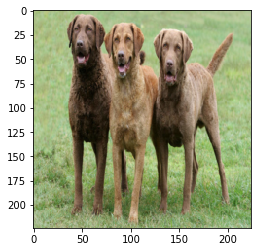

hello, Doggy!
Your predicted breed is....
Chesapeake_bay_retriever

**************************************


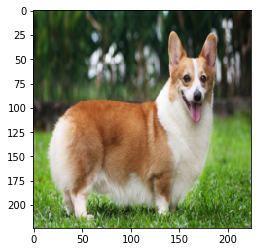

hello, Doggy!
Your predicted breed is....
Pembroke_welsh_corgi

**************************************


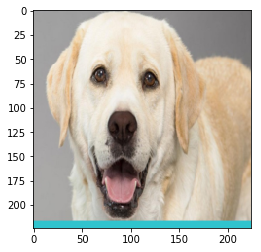

hello, Doggy!
Your predicted breed is....
Labrador_retriever

**************************************


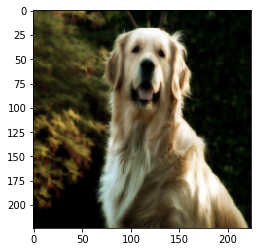

hello, Doggy!
Your predicted breed is....
Golden_retriever

**************************************


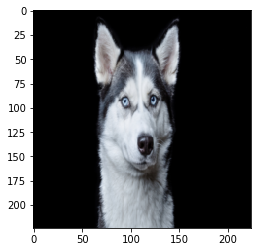

hello, Doggy!
Your predicted breed is....
Alaskan_malamute

**************************************


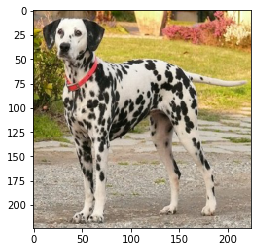

hello, Doggy!
Your predicted breed is....
Dalmatian

**************************************


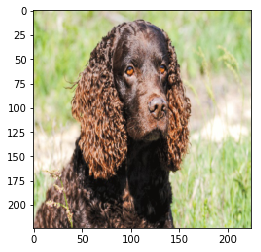

hello, Doggy!
Your predicted breed is....
American_water_spaniel

**************************************


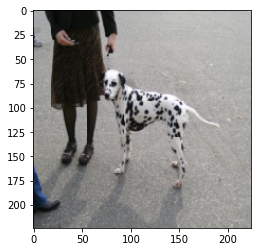

hello, Doggy!
Your predicted breed is....
Dalmatian

**************************************


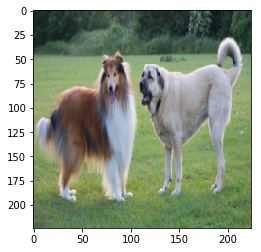

hello, Doggy!
Your predicted breed is....
Collie

**************************************


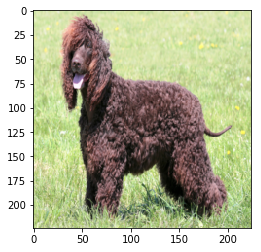

hello, Doggy!
Your predicted breed is....
Irish_water_spaniel

**************************************


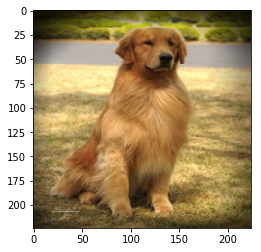

hello, Doggy!
Your predicted breed is....
Golden_retriever

**************************************


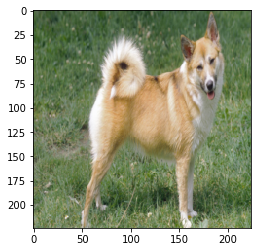

hello, Doggy!
Your predicted breed is....
Icelandic_sheepdog


In [41]:
for d in doggy:
    whos_face_is_this(d)

In [42]:
#load test files from dog-project/Hooman_images
hooman = np.array(glob("Hooman_images/*"))

print('No. of files:', len(hooman))

No. of files: 8



**************************************


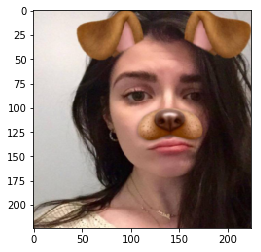

Hello, Human!
You look like a.... 
Chinese_crested

**************************************


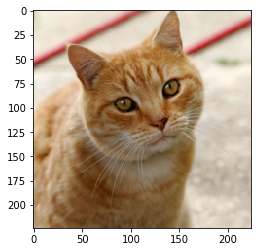

**No face detected..ERROR..**

**************************************


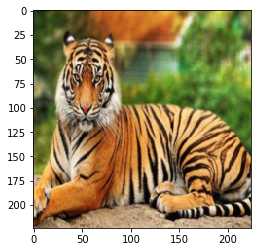

**No face detected..ERROR..**

**************************************


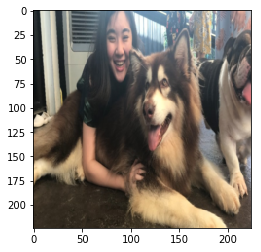

hello, Doggy!
Your predicted breed is....
Alaskan_malamute

**************************************


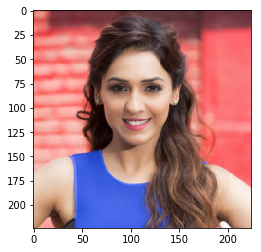

Hello, Human!
You look like a.... 
Poodle

**************************************


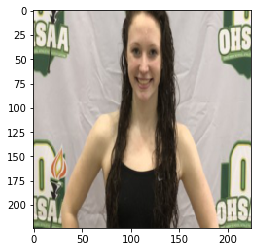

Hello, Human!
You look like a.... 
Belgian_tervuren

**************************************


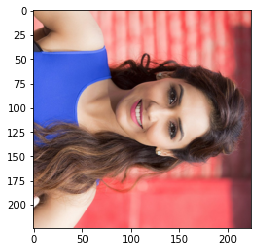

**No face detected..ERROR..**

**************************************


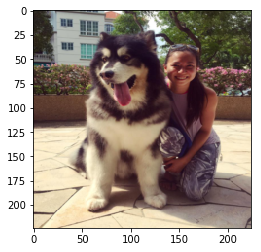

hello, Doggy!
Your predicted breed is....
Alaskan_malamute


In [43]:
for h in hooman:
    whos_face_is_this(h)

In [65]:
#load test files from dog-project/My_Pic
Mypic = np.array(glob("My_Pic/*"))
print('No. of files:', len(Mypic))

No. of files: 2



**************************************


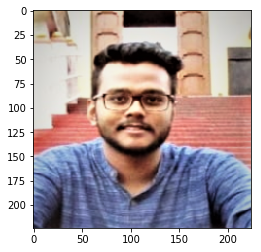

Hello, Human!
You look like a.... 
Bichon_frise

**************************************


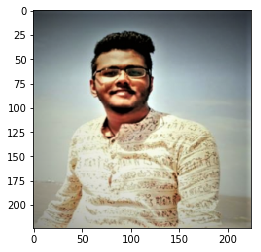

Hello, Human!
You look like a.... 
Bichon_frise


In [66]:
for my in Mypic:
    whos_face_is_this(my)

> **Question 6. Is the output better than you expected:) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.**

__Answer:__ 

Yes, my output is better than i expected as we can see that-
* (American_water_spaniel and Irish_water_spaniel) , (Icelandic_sheepdog,Pembroke_welsh_corgi) looks similar in skin colour but they are predicted 100% correctly, same we can see that retriever dogs like Chesapeake_bay_retriever,Labrador_retriever and Golden_retriever are predicted perfectly . 

* This model predict dog label correctly in group of _same_ dogs(look Chesapeake_bay_retriever).

* This model predict dog label for a dog correcty in _human with dog_ image(look Alaskan_malamute with human).

* This model predict human label for _fake_ dog(camera filter image)- and gave the most resemble label to it as we can Chinese_crested dog has long hairstyles like that girl in pic.

* This model correctly shows error when no face resembleing with human or dog is detected (look cat and tiger).

* This model correctly put same label on my two pics.

>Provide at least three possible points of improvement for your algorithm.

* Earlier as we used harrclassifier for human face detection there we can use one of Bottleneck Features model we used in dog detector to detect human image.

* As we can see 2nd last image of girl that was rotated was not identified by algo due to rotation varience hence Image augumentation is needed here to improve accuracy.

* This can also be improved if algo can identify correctly more than one dog breed in group of different dogs(above 7th img from starting ,there it only identify Collie dog breed and not the other one).

# Please download your notebook to submit

In order to submit, please do the following:
1.  Download an HTML version of the notebook to your computer using 'File: Download as...'
2.  Click on the orange Jupyter circle on the top left of the workspace.
3.  Navigate into the dog-project folder to ensure that you are using the provided dog_images, lfw, and bottleneck_features folders; this means that those folders will *not* appear in the dog-project folder.  If they do appear because you downloaded them, delete them.
4.  While in the dog-project folder, upload the HTML version of this notebook you just downloaded.  The upload button is on the top right.
5.  Navigate back to the home folder by clicking on the two dots next to the folder icon, and then open up a terminal under the 'new' tab on the top right
6.  Zip the dog-project folder with the following command in the terminal:
 `zip -r dog-project.zip dog-project`
7.  Download the zip file by clicking on the square next to it and selecting 'download'.  This will be the zip file you turn in on the next node after this workspace!

In [49]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook dog_app.ipynb to html',
 '[NbConvertApp] Writing 4685248 bytes to dog_app.html']